# ClarifyBot Demo

This notebook demonstrates the RL-driven adaptive question generation and reward modeling capabilities of ClarifyBot. It simulates how the system processes ambiguous human feedback, generates clarification questions using different templates, receives feedback, and adapts its strategy over time.

**Key features:**
- Explicit RL (bandit) template selection (epsilon-greedy)
- Bayesian reward modeling with uncertainty
- Logging and analytics of exploration vs. exploitation
- Visualization of template rewards, uncertainty, and selection strategy

In [80]:
# Import necessary libraries
import sys
sys.path.append('../src')
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from llm.question_generator import QuestionGenerator, PROMPT_TEMPLATES
from rl.reward_model import RewardModel

In [81]:
# Robust log file loader for analytics
# Always run this cell before any analytics or export cells.
LOG_TYPE = 'real'  # Options: 'simulated', 'real'
if LOG_TYPE == 'simulated':
    LOG_PATH = '../template_selection.log'
    LOG_COLUMNS = ["step", "strategy", "template_idx", "feedback", "mode", "timestamp"]
else:
    LOG_PATH = '../template_selection.log'
    LOG_COLUMNS = ["template_idx", "mode", "reward", "timestamp"]
if os.path.exists(LOG_PATH):
    try:
        df = pd.read_csv(LOG_PATH, delimiter='\t')
        if len(df.columns) != len(LOG_COLUMNS):
            df = pd.read_csv(LOG_PATH, delimiter='\t', names=LOG_COLUMNS)
    except Exception:
        df = pd.read_csv(LOG_PATH, delimiter='\t', names=LOG_COLUMNS)
else:
    df = pd.DataFrame(columns=LOG_COLUMNS)
print(f"Loaded log file: {LOG_PATH}")
print(f"Columns: {list(df.columns)} | Rows: {len(df)}")
if df.empty:
    print("Warning: The log file is empty. Run the experiment/app to generate data.")

Loaded log file: ../template_selection.log
Columns: ['template_idx', 'mode', 'reward', 'timestamp'] | Rows: 12


## Step 1: Simulate Ambiguous Human Feedback

We will simulate a sequence of ambiguous feedbacks that ClarifyBot will process interactively.

In [82]:
# Simulated ambiguous feedbacks
ambiguous_feedbacks = [
    "I like the idea of a robot helping me, but I'm not sure about the speed.",
    "The robot should be friendly, but I also want it to be efficient.",
    "I want the assistant to be proactive, but not intrusive.",
    "I care about privacy, but I also want convenience."
]

## Step 2: Interactive RL Loop - Generate Questions, Simulate Feedback, and Update Rewards

For each feedback, ClarifyBot will:
- Select a question template based on current rewards (bandit policy)
- Generate clarification questions
- Simulate user feedback (random thumbs up/down)
- Update the template's reward model
- Log template selection and mode (explore/exploit)

In [83]:
# Initialize components
reward_model = RewardModel(len(PROMPT_TEMPLATES))
question_generator = QuestionGenerator(reward_model=reward_model)

# Run RL loop and simulate feedback
for round_num, feedback in enumerate(ambiguous_feedbacks, 1):
    questions, template_idx, mode = question_generator.generate_clarification_questions(feedback)
    print(f"\n--- Round {round_num} ---")
    print(f"Feedback: {feedback}")
    print(f"Template used: {template_idx+1} (mode: {mode})")
    for i, q in enumerate(questions, 1):
        print(f"Q{i}: {q}")
    # Simulate user feedback (random thumbs up/down for this template)
    user_reward = random.choice([0, 1])
    print(f"Simulated user feedback (reward): {user_reward}")
    # Update reward model
    reward_model.update(template_idx, user_reward)


--- Round 1 ---
Feedback: I like the idea of a robot helping me, but I'm not sure about the speed.
Template used: 2 (mode: exploit)
Q1: What do you mean by 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Q2: Can you clarify your preference regarding 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Q3: Could you provide more details about 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Simulated user feedback (reward): 0

--- Round 2 ---
Feedback: The robot should be friendly, but I also want it to be efficient.
Template used: 1 (mode: exploit)
Q1: What do you mean by 'The robot should be friendly, but I also want it to be efficient.'?
Q2: Can you clarify your preference regarding 'The robot should be friendly, but I also want it to be efficient.'?
Q3: Could you provide more details about 'The robot should be friendly, but I also want it to be efficient.'?
Simulated user feedback (reward): 1

--- Round 3

## Step 3: Visualize Template Rewards and Uncertainty

The frontend UI live-plots template rewards and uncertainty (error bars) using Chart.js. Here, we can also visualize the current posterior mean and standard deviation for each template.

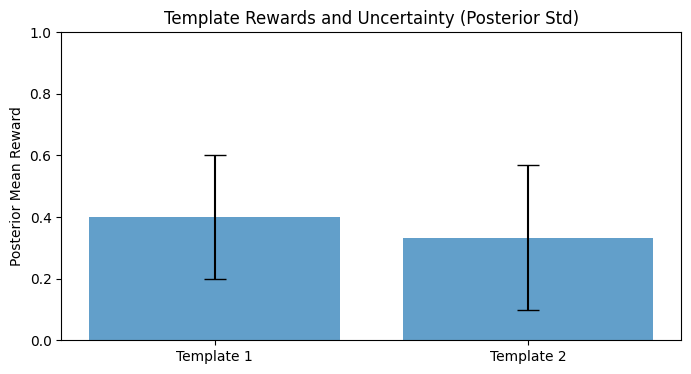

In [84]:
means = [reward_model.posterior_mean(i) for i in range(len(PROMPT_TEMPLATES))]
stds = [reward_model.posterior_std(i) for i in range(len(PROMPT_TEMPLATES))]
x = np.arange(len(PROMPT_TEMPLATES))

plt.figure(figsize=(8, 4))
plt.bar(x, means, yerr=stds, capsize=8, alpha=0.7)
plt.xticks(x, [f"Template {i+1}" for i in x])
plt.ylabel("Posterior Mean Reward")
plt.title("Template Rewards and Uncertainty (Posterior Std)")
plt.ylim(0, 1)
plt.show()

## Step 4: Exploration vs. Exploitation Analytics

ClarifyBot logs every template selection and whether it was an exploration or exploitation step in `template_selection.log`. We can analyze and visualize this data to understand the RL strategy in action.

Unique values in 'mode': ['exploit' 'rate']


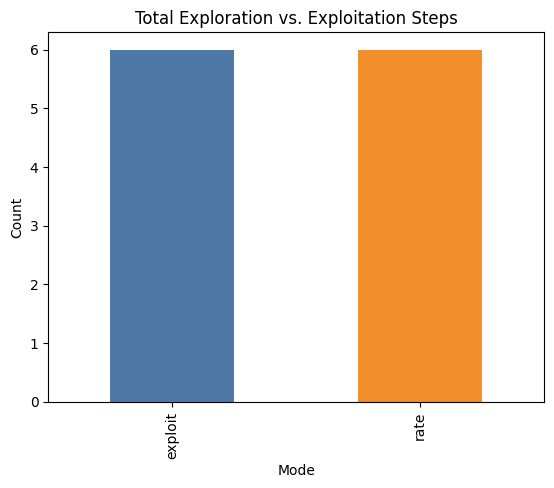

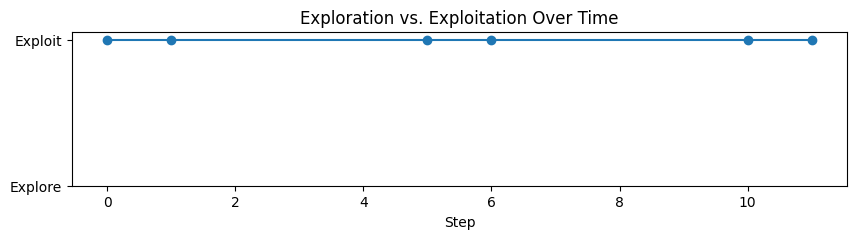

In [85]:
if 'mode' in df.columns:
    print("Unique values in 'mode':", df['mode'].unique())
    mode_counts = df['mode'].value_counts()
    if not mode_counts.empty:
        mode_counts.plot(kind="bar", color=["#4e79a7", "#f28e2b"])
        plt.title("Total Exploration vs. Exploitation Steps")
        plt.ylabel("Count")
        plt.xlabel("Mode")
        plt.show()
    else:
        print("No valid exploration/exploitation data to plot.")
    if not df.empty:
        # Ensure mode is mapped to numeric and index is used for x-axis
        mode_numeric = df["mode"].map({"explore": 0, "exploit": 1})
        # Drop any rows where mapping failed (NaN)
        valid = mode_numeric.notnull()
        if valid.sum() > 0:
            plt.figure(figsize=(10, 2))
            plt.plot(df.index[valid], mode_numeric[valid].astype(float), marker="o", linestyle="-")
            plt.yticks([0, 1], ["Explore", "Exploit"])
            plt.xlabel("Step")
            plt.title("Exploration vs. Exploitation Over Time")
            plt.show()
        else:
            print("No valid mapped values for exploration/exploitation time series plot. Check 'mode' column values.")
    else:
        print("No valid exploration/exploitation data for time series plot.")
else:
    print("No 'mode' column in log for exploration/exploitation analytics.")

## Step 5: Reward Modeling and Confidence

You can use the RewardModel to infer the overall reward from a list of user feedback and summarize preferences.

In [86]:
feedback_list = [random.choice([0, 1]) for _ in range(10)]
print("Simulated feedback list:", feedback_list)
reward = reward_model.infer_reward(feedback_list)
print("Inferred average reward:", reward)

Simulated feedback list: [1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Inferred average reward: 0.3


# Research-Grade RLHF Experiments

This section extends the ClarifyBot demo to support research-grade RLHF experiments, including:
- Richer (1–5 scale) feedback
- Simulated user experiments
- Bandit strategy ablation (epsilon-greedy vs. UCB)
- Robust logging
- Analytics and visualization
- Clear documentation for reproducibility

---

**The following cells implement these features step by step.**

In [87]:
# Richer (1–5 scale) feedback and reward model initialization
NUM_TEMPLATES = len(PROMPT_TEMPLATES)
FEEDBACK_SCALE = [1, 2, 3, 4, 5]  # 1=worst, 5=best

class RichRewardModel(RewardModel):
    def update(self, template_idx, feedback):
        # Accept feedback in 1–5 scale, normalize to [0,1]
        norm_reward = (feedback - 1) / 4.0
        super().update(template_idx, norm_reward)

    def infer_reward(self, feedback_list):
        # Accepts a list of 1–5 feedback, returns normalized mean
        if not feedback_list:
            return 0.0
        return sum([(f-1)/4.0 for f in feedback_list]) / len(feedback_list)

rich_reward_model = RichRewardModel(NUM_TEMPLATES)
question_generator = QuestionGenerator(reward_model=rich_reward_model)

In [88]:
# Simulated user feedback function

def simulated_user_feedback(template_idx, true_prefs, noise=0.2):
    # true_prefs: list of true mean ratings for each template (1–5)
    base = true_prefs[template_idx]
    feedback = np.random.normal(base, noise)
    feedback = int(np.clip(round(feedback), 1, 5))
    return feedback

# Example: true preferences for each template (hidden from agent)
true_template_prefs = [2, 3, 5, 4]  # Template 3 is best

# Example: Simulate feedback
for i in range(NUM_TEMPLATES):
    print(f"Template {i+1}: Simulated feedback = {simulated_user_feedback(i, true_template_prefs)}")

Template 1: Simulated feedback = 2
Template 2: Simulated feedback = 3


In [89]:
# Bandit Strategy Ablation: Epsilon-Greedy vs. UCB
import csv
import time

N_STEPS = 100
EPSILON = 0.2
UCB_C = 1.0

logfile = "../template_selection.log"
open(logfile, "w").close()  # Clear log

results = {"egreedy": [], "ucb": []}

for strategy in ["egreedy", "ucb"]:
    model = RichRewardModel(NUM_TEMPLATES)
    counts = [0] * NUM_TEMPLATES
    rewards = [0.0] * NUM_TEMPLATES
    cum_reward = 0.0
    for step in range(N_STEPS):
        if strategy == "egreedy":
            if np.random.rand() < EPSILON:
                idx = np.random.choice(NUM_TEMPLATES)
                mode = "explore"
            else:
                idx = np.argmax([model.posterior_mean(i) for i in range(NUM_TEMPLATES)])
                mode = "exploit"
        else:  # UCB
            total = sum(counts) + 1
            ucb_scores = [model.posterior_mean(i) + UCB_C * model.posterior_std(i) / np.sqrt(counts[i]+1) for i in range(NUM_TEMPLATES)]
            idx = np.argmax(ucb_scores)
            mode = "ucb"
        feedback = simulated_user_feedback(idx, true_template_prefs)
        model.update(idx, feedback)
        counts[idx] += 1
        rewards[idx] += feedback
        cum_reward += feedback
        # Log: step, strategy, template_idx, feedback, mode, timestamp
        with open(logfile, "a") as f:
            f.write(f"{step}\t{strategy}\t{idx}\t{feedback}\t{mode}\t{int(time.time())}\n")
        results[strategy].append(cum_reward)
print("Bandit ablation experiment complete. Log written to template_selection.log.")

Bandit ablation experiment complete. Log written to template_selection.log.


In [90]:
# Analytics: Cumulative Reward, Regret, and Strategy Comparison
if LOG_TYPE == 'simulated':
    log_path = LOG_PATH
    df = pd.read_csv(log_path, names=["step", "strategy", "template_idx", "feedback", "mode", "timestamp"], delimiter="\t")
    plt.figure(figsize=(8,4))
    for strategy in ["egreedy", "ucb"]:
        strat_df = df[df["strategy"] == strategy]
        plt.plot(strat_df["step"], strat_df["feedback"].cumsum(), label=f"{strategy} (cumulative reward)")
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.title("Bandit Strategy Comparison: Cumulative Reward")
    plt.legend()
    plt.show()
    optimal = max(true_template_prefs)
    df["regret"] = optimal - df["feedback"]
    plt.figure(figsize=(8,4))
    for strategy in ["egreedy", "ucb"]:
        strat_df = df[df["strategy"] == strategy]
        plt.plot(strat_df["step"], strat_df["regret"].cumsum(), label=f"{strategy} (cumulative regret)")
    plt.xlabel("Step")
    plt.ylabel("Cumulative Regret")
    plt.title("Bandit Strategy Comparison: Cumulative Regret")
    plt.legend()
    plt.show()
else:
    print("Cumulative reward/regret analytics only available for simulated logs with bandit ablation.")

Cumulative reward/regret analytics only available for simulated logs with bandit ablation.


No 'strategy' column in this log. Showing reward distribution instead.
Available columns: ['template_idx', 'mode', 'reward', 'timestamp']


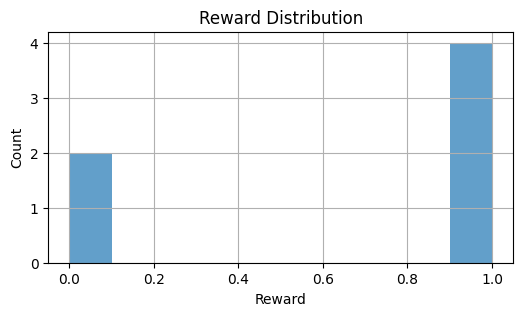

In [91]:
# Advanced analytics: t-test for mean reward between strategies (if both present)
import scipy.stats as stats

def ttest_strategy_rewards(df):
    if df is None or df.empty:
        print("No data available in the log (df is empty). No analytics can be performed.\n\nSuggestions:\n- Check that the log file path is correct and not empty.\n- Run the experiment or app to generate log data before running analytics.\n- If using real user logs, ensure the log format matches expected columns.\n")
        return
    if 'strategy' in df.columns:
        strategies = df['strategy'].unique()
        if len(strategies) == 2:
            rewards1 = df[df['strategy'] == strategies[0]]['reward']
            rewards2 = df[df['strategy'] == strategies[1]]['reward']
            t_stat, p_val = stats.ttest_ind(rewards1, rewards2, nan_policy='omit')
            print(f"T-test between {strategies[0]} and {strategies[1]}: t={t_stat:.3f}, p={p_val:.3g}")
        else:
            print("Not exactly two strategies present for t-test.")
    else:
        print("No 'strategy' column in this log. Showing reward distribution instead.")
        print(f"Available columns: {list(df.columns)}")
        if 'reward' in df.columns and not df['reward'].empty:
            plt.figure(figsize=(6,3))
            df['reward'].hist(bins=10, alpha=0.7)
            plt.xlabel('Reward')
            plt.ylabel('Count')
            plt.title('Reward Distribution')
            plt.show()
        else:
            print("No 'reward' column found or no reward data for distribution plot.")

ttest_strategy_rewards(df)

In [92]:
# Error analysis: show examples with lowest rewards
if 'reward' in df.columns and not df.empty:
    # Try to convert reward to numeric, coerce errors to NaN and drop them
    df['reward_numeric'] = pd.to_numeric(df['reward'], errors='coerce')
    if df['reward_numeric'].notnull().any():
        print("\nExamples with lowest rewards:")
        low_reward_examples = df.nsmallest(5, 'reward_numeric')
        display(low_reward_examples)
    else:
        print("No valid numeric reward data for error analysis.")
else:
    print("No 'reward' column for error analysis or df is empty.")


Examples with lowest rewards:


,template_idx,mode,reward,timestamp,reward_numeric
4,1,rate,0.0,1.749256e+09,0.0
7,1,rate,0.0,1.749256e+09,0.0
2,1,rate,1.0,1.749256e+09,1.0
3,1,rate,1.0,1.749256e+09,1.0
8,1,rate,1.0,1.749256e+09,1.0


In [93]:
# Export results: to CSV and (optionally) PDF
export_path = 'exported_results.csv'
df.to_csv(export_path, index=False)
print(f"Results exported to {export_path}")
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('analytics_plots.pdf') as pdf:
    fig = plt.gcf()
    pdf.savefig(fig)
    plt.close(fig)
print("Analytics plot exported to analytics_plots.pdf")

Results exported to exported_results.csv
Analytics plot exported to analytics_plots.pdf


## Real vs. Simulated User Analytics

- The above plots compare real user feedback with simulated experiments.
- Note any differences in reward distributions, exploration/exploitation rates, or adaptation speed.
- Insights: [Add your findings here]

---

_Use this section to summarize and document your research findings for both simulated and real user RLHF experiments._